In [1]:
from gensim.models import KeyedVectors
from tqdm import tqdm
import pandas as pd
import numpy as np
import string
import re
import torch
import torch.nn as nn

### 70

In [6]:
w2vModel = KeyedVectors.load_word2vec_format('src/GoogleNews-vectors-negative300.bin.gz', binary=True)

train=pd.read_csv('src/newcorpora/train.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
valid=pd.read_csv('src/newcorpora/valid.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
test=pd.read_csv('src/newcorpora/test.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])

In [7]:
def normalizeText(text):
    text = text.lower()  # 小文字化
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = re.sub('[0-9|,|.]+', '0', text)
    text = text.translate(table)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"^ | $", "", text)
    return text

In [8]:
def get_title_vector(title):
    size=w2vModel.vector_size
    vec=[w2vModel[word] if word in w2vModel.vocab else [0]*size for word in title.split()]
    vec= np.mean(np.array(vec),axis=0)
    return vec

In [9]:
X_train=np.array(list(map(get_title_vector, train.TITLE.map(lambda x: normalizeText(x)))))
X_valid=np.array(list(map(get_title_vector, valid.TITLE.map(lambda x: normalizeText(x)))))
X_test=np.array(list(map(get_title_vector, test.TITLE.map(lambda x: normalizeText(x)))))

# pd.DataFrame(X_train).to_csv("src/wordsim353/X_train.txt",sep="\t",header=None,index=None)
# pd.DataFrame(X_valid).to_csv("src/wordsim353/X_valid.txt",sep="\t",header=None,index=None)
# pd.DataFrame(X_test).to_csv("src/wordsim353/X_valid.txt",sep="\t",header=None,index=None)

y_train=train["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_valid=valid["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_test=test["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})

# pd.Series(y_train).to_csv("src/wordsim353/y_train.txt",header=None,index=None)
# pd.Series(y_valid).to_csv("src/wordsim353/y_valid.txt",header=None,index=None)
# pd.Series(y_test).to_csv("src/wordsim353/y_test.txt",header=None,index=None)

In [10]:
d=w2vModel.vector_size
L=4

### 71

In [7]:
X=torch.tensor(X_train[:4],dtype=torch.float32)
W=torch.randn(size=[300,4])
softmax = nn.Softmax(dim=1)
softmax(X.matmul(W))

tensor([[0.1338, 0.1772, 0.1538, 0.5352],
        [0.2960, 0.3814, 0.1253, 0.1974],
        [0.0255, 0.4356, 0.3023, 0.2366],
        [0.0377, 0.0526, 0.4280, 0.4818]])

別実装

### 72

In [25]:
criterion=nn.CrossEntropyLoss()

In [37]:
y_pred = neuralModel(X)
y_true=torch.tensor(y_train[:4],dtype=torch.int64)
print(y_pred)

tensor([[-0.0563,  1.6913, -0.2063, -1.1848],
        [ 4.0888, -2.2877, -0.1979, -1.4350],
        [ 4.7767, -2.4733, -0.4913, -1.7425],
        [-1.3681,  4.3502, -0.4973, -2.4993]], grad_fn=<AddmmBackward>)


In [13]:
y_true=torch.tensor(y_train[:4],dtype=torch.int64)

In [14]:
CrossEntropyLoss(torch.matmul(X, W),y_true)

tensor(2.3910)

### 73

In [2]:
import torch.optim as optim

In [11]:
INPUT_FEATURES=d
OUTPUT_NEURONS=L

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        
        self.layer1=nn.Linear(
        INPUT_FEATURES,
        OUTPUT_NEURONS
        )
    def forward(self,input_data):
        return self.layer1(input_data)

In [17]:
X=torch.tensor(X_train[:4],dtype=torch.float32)
W=torch.randn(size=[300,4])
softmax = nn.Softmax(dim=1)
softmax(X.matmul(W))

tensor([[0.6418, 0.1027, 0.1786, 0.0770],
        [0.8805, 0.0396, 0.0470, 0.0328],
        [0.4327, 0.1164, 0.1437, 0.3072],
        [0.4955, 0.0179, 0.2197, 0.2669]])

In [13]:
def is_equal_pred(pred_y,true_y):
    return activation(pred_y).argmax(axis=1) == true_y

def train_step(train_X, train_y):
    neuralModel.train()
    pred_y = neuralModel(train_X)
    
    optimizer.zero_grad()
    loss = criterion(pred_y, train_y)
    loss.backward()
    optimizer.step()
    
    n=len(train_y)
    
    acc = is_equal_pred(pred_y,train_y).sum()
    
    return (loss.item(), acc.item()/n)

def valid_step(valid_X, valid_y):
    neuralModel.eval()
    pred_y = neuralModel(valid_X)
    
    loss = criterion(pred_y, valid_y)
    
    n=len(valid_y)
    acc = is_equal_pred(pred_y,valid_y).sum()

    return (loss.item(), acc.item()/n)

def init_parameters(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.0)
#         layer.weight.grad = None
#         layer.bias.grad = None

In [15]:
neuralModel=NeuralNetwork()
# optimizer
LEARNING_RATE = 1
# REGULARIZATION = 0.01
optimizer = optim.SGD(
    neuralModel.parameters(),
    lr=LEARNING_RATE)
#     ,weight_decay=REGULARIZATION)

# activation
activation = torch.nn.Softmax(dim=1)

# criterion
criterion=nn.CrossEntropyLoss()

In [14]:
train_X=torch.tensor(X_train,dtype=torch.float32)
train_y=torch.tensor(y_train,dtype=torch.int64)
valid_X=torch.tensor(X_valid,dtype=torch.float32)
valid_y=torch.tensor(y_valid,dtype=torch.int64)
test_X=torch.tensor(X_test,dtype=torch.float32)
test_y=torch.tensor(y_test,dtype=torch.int64)

train_n=len(train_y)
valid_n=len(valid_y)
test_n=len(test_y)

In [16]:
neuralModel.apply(init_parameters)
EPOCHS = 100
train_history_loss = []
train_history_acc = []
valid_history_loss = []
valid_history_acc = []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc=train_step(train_X,train_y)
    valid_loss, valid_acc=valid_step(valid_X, valid_y)
    train_history_loss.append(train_loss)
    train_history_acc.append(train_acc)
    valid_history_loss.append(valid_loss)
    valid_history_acc.append(valid_acc)

100%|██████████| 100/100 [00:00<00:00, 226.20it/s]


In [18]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'epocs')

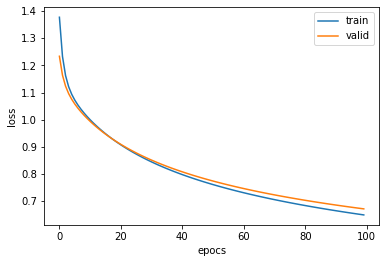

In [19]:
plt.plot(train_history_loss,label="train")
plt.plot(valid_history_loss,label="valid")
plt.legend()
plt.ylabel("loss")
plt.xlabel("epocs")

Text(0.5, 0, 'epocs')

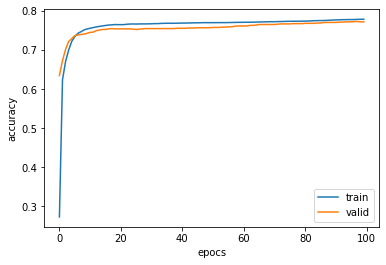

In [20]:
plt.plot(np.array(train_history_acc),label="train")
plt.plot(np.array(valid_history_acc),label="valid")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("epocs")

### 74

In [61]:
pred_train_X=neuralModel(train_X)
pred_valid_X=neuralModel(valid_X)
pred_test_X=neuralModel(test_X)
acc_train=np.array(is_equal_pred(pred_train_X,train_y)).mean()
acc_valid=np.array(is_equal_pred(pred_valid_X,valid_y)).mean()
acc_test=np.array(is_equal_pred(pred_test_X,test_y)).mean()

print(acc_train)
print(acc_valid)
print(acc_test)

0.7784857571214393
0.7698650674662668
0.7818590704647677


### 75

In [28]:
from torch.utils.tensorboard import SummaryWriter

In [67]:
!rm -rf ./logs

neuralModel=NeuralNetwork()
# optimizer
LEARNING_RATE = 1
# REGULARIZATION = 0.01
optimizer = optim.SGD(
    neuralModel.parameters(),
    lr=LEARNING_RATE)
#     ,weight_decay=REGULARIZATION)


%load_ext tensorboard
%tensorboard --logdir ./logs

neuralModel.apply(init_parameters)
EPOCHS = 1000
train_history_loss = []
train_history_acc = []
valid_history_loss = []
valid_history_acc = []

writer = SummaryWriter(log_dir="./logs")

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc=train_step(train_X,train_y)
    valid_loss, valid_acc=valid_step(valid_X, valid_y)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Acc/train", train_acc, epoch)
    writer.add_scalar("Loss/valid", valid_loss, epoch)
    writer.add_scalar("Acc/valid", valid_acc, epoch)
    
writer.close()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 77324), started 0:44:48 ago. (Use '!kill 77324' to kill it.)

100%|██████████| 1000/1000 [00:06<00:00, 162.52it/s]


### 76

In [27]:
import datetime

In [131]:
!rm -rf ./logs

neuralModel=NeuralNetwork()
# optimizer
LEARNING_RATE = 1
# REGULARIZATION = 0.01
optimizer = optim.SGD(
    neuralModel.parameters(),
    lr=LEARNING_RATE)
#     ,weight_decay=REGULARIZATION)

In [132]:

%tensorboard --logdir ./logs

neuralModel.apply(init_parameters)
EPOCHS = 1000
train_history_loss = []
train_history_acc = []
valid_history_loss = []
valid_history_acc = []

writer = SummaryWriter(log_dir="./logs")
nowstr=datetime.datetime.now().strftime('%Y%m%d_%H%M')
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc=train_step(train_X,train_y)
    valid_loss, valid_acc=valid_step(valid_X, valid_y)
    
    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Acc/train", train_acc, epoch)
        writer.add_scalar("Loss/valid", valid_loss, epoch)
        writer.add_scalar("Acc/valid", valid_acc, epoch)

        torch.save(neuralModel.state_dict(), 'output/'+nowstr+"_"+str(epoch)+'.model')
        torch.save(optimizer.state_dict(), 'output/'+nowstr+"_"+str(epoch)+'.param')

writer.close()

Reusing TensorBoard on port 6006 (pid 77324), started 2:03:54 ago. (Use '!kill 77324' to kill it.)

100%|██████████| 1000/1000 [00:07<00:00, 142.78it/s]


In [90]:
modelload = NeuralNetwork()
modelload.load_state_dict(torch.load('output/'+nowstr+"_"+str(0)+'.model'))

pred_train_X=modelload(train_X)
pred_valid_X=modelload(valid_X)
pred_test_X=modelload(test_X)
acc_train=np.array(is_equal_pred(pred_train_X,train_y)).mean()
acc_valid=np.array(is_equal_pred(pred_valid_X,valid_y)).mean()
acc_test=np.array(is_equal_pred(pred_test_X,test_y)).mean()

print(acc_train)
print(acc_valid)
print(acc_test)

0.5121814092953523
0.5082458770614693
0.5217391304347826


### 77

In [23]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
!rm -rf ./logs

neuralModel=NeuralNetwork()
# optimizer
LEARNING_RATE = 1
# REGULARIZATION = 0.01
optimizer = optim.SGD(
    neuralModel.parameters(),
    lr=LEARNING_RATE)
#     ,weight_decay=REGULARIZATION)

In [122]:
%tensorboard --logdir ./logs

EPOCHS = 10
train_history_loss = []
train_history_acc = []
valid_history_loss = []
valid_history_acc = []

ds_train = TensorDataset(train_X, train_y)
ds_valid = TensorDataset(valid_X, valid_y)

writer = SummaryWriter(log_dir="./logs")

nowstr=datetime.datetime.now().strftime('%Y%m%d_%H%M')

batchsizes=np.logspace(0, 10, 11, base=2,dtype=int)
# batchsizes=np.logspace(0, 10, 11, base=2,dtype=int)

for b in tqdm(batchsizes):
    neuralModel=NeuralNetwork()
    # optimizer
    LEARNING_RATE = 1
    # REGULARIZATION = 0.01
    optimizer = optim.SGD(
        neuralModel.parameters(),
        lr=LEARNING_RATE)
    neuralModel.apply(init_parameters)
    
    loader_train = DataLoader(ds_train, batch_size=int(b), shuffle=True)
    loader_valid = DataLoader(ds_valid, batch_size=int(b), shuffle=True)
    for epoch in range(EPOCHS):
        train_loss_mean=[]
        train_acc_mean=[]
        for x,y in loader_train:
            train_loss, train_acc=train_step(train_X,train_y)
            train_loss_mean.append(train_loss)
            train_acc_mean.append(train_acc)

        valid_loss_mean=[]
        valid_acc_mean=[]
        for x,y in loader_valid:
            valid_loss, valid_acc=valid_step(valid_X, valid_y)
            valid_loss_mean.append(valid_loss)
            valid_acc_mean.append(valid_acc)

        train_loss_mean=np.mean(train_loss_mean)
        train_acc_mean=np.mean(train_acc_mean)
        valid_loss_mean=np.mean(valid_loss_mean)
        valid_acc_mean=np.mean(valid_acc_mean)

        with torch.no_grad():
            writer.add_scalar("Loss/train", train_loss_mean, epoch)
            writer.add_scalar("Acc/train", train_acc_mean, epoch)
            writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
            writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

            torch.save(neuralModel.state_dict(), f"output/date{nowstr}_batch{b}_epoch{epoch}.model")
            torch.save(optimizer.state_dict(), f"output/date{nowstr}_batch{b}_epoch{epoch}.param")

writer.close()

Reusing TensorBoard on port 6006 (pid 77324), started 1:24:48 ago. (Use '!kill 77324' to kill it.)

100%|██████████| 11/11 [14:04<00:00, 76.79s/it]  


In [127]:
acc_trains=[]
acc_valids=[]
acc_tests=[]
for b in batchsizes:
    modelload = NeuralNetwork()
    modelload.load_state_dict(torch.load(f"output/date{nowstr}_batch{b}_epoch{9}.model"))
    pred_train_X=modelload(train_X)
    pred_valid_X=modelload(valid_X)
    pred_test_X=modelload(test_X)
    acc_train=np.array(is_equal_pred(pred_train_X,train_y)).mean()
    acc_valid=np.array(is_equal_pred(pred_valid_X,valid_y)).mean()
    acc_test=np.array(is_equal_pred(pred_test_X,test_y)).mean()
    acc_trains.append(acc_train)
    acc_valids.append(acc_valid)
    acc_tests.append(acc_test)
    print(f"{b}:\t{acc_train}\t{acc_valid}\t{acc_test}")

1:	0.9180097451274363	0.8823088455772113	0.8928035982008995
2:	0.9160419790104948	0.8830584707646177	0.8973013493253373
4:	0.9131371814092953	0.8830584707646177	0.8988005997001499
8:	0.9081709145427287	0.883808095952024	0.8973013493253373
16:	0.9010494752623688	0.8823088455772113	0.8920539730134932
32:	0.8927098950524738	0.8800599700149925	0.8860569715142429
64:	0.8839017991004497	0.868815592203898	0.8853073463268366
128:	0.8728448275862069	0.8590704647676162	0.8823088455772113
256:	0.8514805097451275	0.841079460269865	0.8643178410794603
512:	0.8180284857571214	0.8050974512743628	0.8305847076461769
1024:	0.7825149925037481	0.7736131934032984	0.7863568215892054


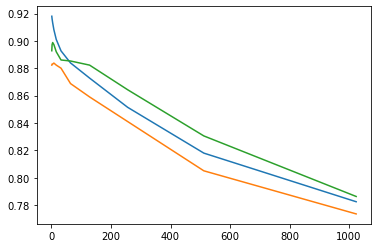

In [129]:
plt.plot(batchsizes,acc_trains)
plt.plot(batchsizes,acc_valids)
plt.plot(batchsizes,acc_tests)

### 78

In [ ]:
%load_ext tensorboard

In [51]:
device = torch.device("cpu")
print(device)

cpu


In [61]:
!rm -rf ./logs

neuralModel=NeuralNetwork()

neuralModel = neuralModel.to(device)
# optimizer
LEARNING_RATE = 1
# REGULARIZATION = 0.01
optimizer = optim.SGD(
    neuralModel.parameters(),
    lr=LEARNING_RATE)
#     ,weight_decay=REGULARIZATION)

In [63]:
%tensorboard --logdir ./logs

EPOCHS = 100
train_history_loss = []
train_history_acc = []
valid_history_loss = []
valid_history_acc = []

ds_train = TensorDataset(train_X.to(device), train_y.to(device))
ds_valid = TensorDataset(valid_X.to(device), valid_y.to(device))

writer = SummaryWriter(log_dir="./logs")

nowstr=datetime.datetime.now().strftime('%Y%m%d_%H%M')

batchsize=32
# batchsizes=np.logspace(0, 10, 11, base=2,dtype=int)

neuralModel.apply(init_parameters)

loader_train = DataLoader(ds_train, batch_size=batchsize, shuffle=True)
loader_valid = DataLoader(ds_valid, batch_size=batchsize, shuffle=True)
for epoch in range(EPOCHS):
    train_loss_mean=[]
    train_acc_mean=[]
    for x,y in loader_train:
        train_loss, train_acc=train_step(train_X,train_y)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)

    valid_loss_mean=[]
    valid_acc_mean=[]
    for x,y in loader_valid:
        valid_loss, valid_acc=valid_step(valid_X, valid_y)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)

    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)

    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

#         torch.save(neuralModel.state_dict(), f"output/date{nowstr}_batch{b}_epoch{epoch}.model")
#         torch.save(optimizer.state_dict(), f"output/date{nowstr}_batch{b}_epoch{epoch}.param")

writer.close()

### 79

In [234]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
w2vModel = KeyedVectors.load_word2vec_format('src/GoogleNews-vectors-negative300.bin.gz', binary=True)

train=pd.read_csv('src/newcorpora/train.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
valid=pd.read_csv('src/newcorpora/valid.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])
test=pd.read_csv('src/newcorpora/test.txt', sep="\t",header=None,names=["CATEGORY", "TITLE"])

In [200]:
size=w2vModel.vector_size
vecs=[]
for word in title.split():
    w=train_feature[word][0] if word in train_feature.columns else 0
    vec=w2vModel[word] if word in w2vModel.vocab else np.zeros(size)
    vec=w*vec
    if not np.all(vec==0):
        vecs.append(vec)
    return np.mean(vecs,axis=0)

In [338]:
columns=train_feature.columns

def get_title_vector_weighted(title,i,feature):
    size=w2vModel.vector_size
    vecs=[]
    for word in title.split():
        w=feature[word][i] if word in columns else 0
        vec=w2vModel[word] if word in w2vModel.vocab else np.zeros(size)
        vec=w*vec
        if np.all(vec==0.0):
            continue
        vecs.append(vec)
    return np.array(vecs).mean(axis=0)

In [313]:
Tfidfvec = TfidfVectorizer(max_df=0.9)#,max_features=1000, ngram_range=(1, 2))

train_vec=Tfidfvec.fit_transform(train.TITLE.map(lambda x: normalizeText(x)))
valid_vec=Tfidfvec.transform(valid.TITLE.map(lambda x: normalizeText(x)))
test_vec=Tfidfvec.transform(test.TITLE.map(lambda x: normalizeText(x)))

train_feature=pd.DataFrame(train_vec.toarray(), columns=Tfidfvec.get_feature_names())
valid_feature=pd.DataFrame(valid_vec.toarray(), columns=Tfidfvec.get_feature_names())
test_feature=pd.DataFrame(test_vec.toarray(), columns=Tfidfvec.get_feature_names())

In [341]:
X_train=[]
for i,title in enumerate(train.TITLE):
    title=normalizeText(title)
    X_train.append(get_title_vector_weighted(title,i,train_feature))
X_train=np.array(X_train)

X_valid=[]
for i,title in enumerate(valid.TITLE):
    title=normalizeText(title)
    X_valid.append(get_title_vector_weighted(title,i,valid_feature))
X_valid=np.array(X_valid)

X_test=[]
for i,title in enumerate(test.TITLE):
    title=normalizeText(title)
    X_test.append(get_title_vector_weighted(title,i,test_feature))
X_test=np.array(X_test)

y_train=train["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_valid=valid["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})
y_test=test["CATEGORY"].map({'b':0,'e':1,'t':2,'m':3})

In [345]:
train_X=torch.tensor(X_train,dtype=torch.float32)
train_y=torch.tensor(y_train,dtype=torch.int64)
valid_X=torch.tensor(X_valid,dtype=torch.float32)
valid_y=torch.tensor(y_valid,dtype=torch.int64)
test_X=torch.tensor(X_test,dtype=torch.float32)
test_y=torch.tensor(y_test,dtype=torch.int64)

train_n=len(train_y)
valid_n=len(valid_y)
test_n=len(test_y)

In [243]:
valid_X.shape

torch.Size([10, 300])

In [346]:
ReLU=nn.ReLU()
Sigmoid=nn.Sigmoid()
MIDDLE_NEURONS=32

class MultiNeuralNetwork(nn.Module):
    def __init__(self):
        super(MultiNeuralNetwork,self).__init__()
        
        self.layer1=nn.Linear(
        INPUT_FEATURES,
        MIDDLE_NEURONS
        )
        self.layer2=nn.Linear(
        MIDDLE_NEURONS,
        OUTPUT_NEURONS
        )
    def forward(self,input_data):
        h1=self.layer1(input_data)
        h2=Sigmoid(h1)
        h3=self.layer2(h2)
        return h3

In [347]:
def train_step(train_X, train_y,model):
    model.train()
    pred_y = model(train_X)
    
    optimizer.zero_grad()
    loss = criterion(pred_y, train_y)
    loss.backward()
    optimizer.step()
    
    n=len(train_y)
    
    acc = is_equal_pred(pred_y,train_y).sum()
    
    return (loss.item(), acc.item()/n)

def valid_step(valid_X, valid_y,model):
    model.eval()
    pred_y = model(valid_X)
    
    loss = criterion(pred_y, valid_y)
    
    n=len(valid_y)
    acc = is_equal_pred(pred_y,valid_y).sum()

    return (loss.item(), acc.item()/n)

In [356]:
!rm -rf ./logs

multiNeuralModel=MultiNeuralNetwork()

multiNeuralModel = multiNeuralModel.to(device)
# optimizer
REGULARIZATION = 0.0001
optimizer = optim.Adadelta(
    multiNeuralModel.parameters(),weight_decay=REGULARIZATION)
# ,
#     lr=LEARNING_RATE
#      )

In [118]:
EPOCHS=100

In [358]:
%tensorboard --logdir ./logs

ds_train = TensorDataset(train_X.to(device), train_y.to(device))
ds_valid = TensorDataset(valid_X.to(device), valid_y.to(device))

writer = SummaryWriter(log_dir="./logs")

nowstr=datetime.datetime.now().strftime('%Y%m%d_%H%M')

batchsize=128
# batchsizes=np.logspace(0, 10, 11, base=2,dtype=int)

multiNeuralModel.apply(init_parameters)

loader_train = DataLoader(ds_train, batch_size=batchsize, shuffle=True)
loader_valid = DataLoader(ds_valid, batch_size=batchsize, shuffle=True)
for epoch in range(EPOCHS):
    train_loss_mean=[]
    train_acc_mean=[]
    for x,y in loader_train:
        train_loss, train_acc=train_step(train_X,train_y,multiNeuralModel)
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)

    valid_loss_mean=[]
    valid_acc_mean=[]
    for x,y in loader_valid:
        valid_loss, valid_acc=valid_step(valid_X, valid_y,multiNeuralModel)
        valid_loss_mean.append(valid_loss)
        valid_acc_mean.append(valid_acc)

    train_loss_mean=np.mean(train_loss_mean)
    train_acc_mean=np.mean(train_acc_mean)
    valid_loss_mean=np.mean(valid_loss_mean)
    valid_acc_mean=np.mean(valid_acc_mean)

    with torch.no_grad():
        writer.add_scalar("Loss/train", train_loss_mean, epoch)
        writer.add_scalar("Acc/train", train_acc_mean, epoch)
        writer.add_scalar("Loss/valid", valid_loss_mean, epoch)
        writer.add_scalar("Acc/valid", valid_acc_mean, epoch)

#         torch.save(neuralModel.state_dict(), f"output/date{nowstr}_batch{b}_epoch{epoch}.model")
#         torch.save(optimizer.state_dict(), f"output/date{nowstr}_batch{b}_epoch{epoch}.param")

writer.close()